In [ ]:

import pandas as pd
import numpy as np
import os
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

import tqdm
#All tensorflow utilities for creating, training and working with a CNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPool1D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import  tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler




In [ ]:


path = '/content/drive/MyDrive/1-bez'
os.chdir(path)
csv_files = glob.glob(os.path.join(path, "*.csv"))

df= pd.DataFrame()
for i in (csv_files):
    data = pd.read_csv(i)
    df = df.append(data, ignore_index=True)

date = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df['date'] = date



df.head()
df.isnull().sum(axis=0).sort_values(ascending = False)
df.describe()
list(df)

col = df.pop("date")
df.insert(0, "date", col)

In [ ]:

# drop unsued columns
df.drop(['No','year', 'month','day', 'hour'], axis =1, inplace = True)


df.isnull().sum(axis =0).sort_values(ascending = False)

# fill na value with backward fill

df.fillna(method='bfill', inplace=True)

# check na values

df.isnull().sum(axis =0).sort_values(ascending = False)


# encode classes, in this case wd and station

label_encoder = LabelEncoder()

encoder_labels_station = label_encoder.fit_transform(df.station)

df['label_station'] = encoder_labels_station



encoder_labels_wd = label_encoder.fit_transform(df.wd)

df['label_wd'] = encoder_labels_wd



# remove columns with string value

df.drop(['station', 'wd'], axis =1, inplace = True)

In [ ]:

# split data into training and testing dataset


df.set_index('date', inplace = True)
df.sort_values('date', inplace = True)

X_train = df.iloc[0:(round(0.8*len(df))),]
X_test = df.loc[df.index > str(X_train.index[-1])]





#scale data between -1 1


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

ct = ColumnTransformer([
        ('somename', MinMaxScaler(feature_range=(-1,1)), list(X_train.iloc[:, 2:]))
    ], remainder='passthrough')


X_train_scaled = ct.fit_transform(X_train)
X_test_scaled = ct.fit_transform(X_test)



# fix columns and indexes

f =  [X_train.columns[2:].append(X_test.columns[[0,1]])]

X_train_scaled = pd.DataFrame(X_train_scaled, index = X_train.index , columns=f)
X_test_scaled = pd.DataFrame(X_test_scaled, index = X_test.index , columns=f)




In [ ]:

#Create sequences
def create_sequence(input_data, X,  target_column, sequence_length):
    
    sequences_x=[]
    sequences_y = []
    data_size = len(input_data)
    
    
    for k in range(data_size - sequence_length):
        
        
        sequence = X[k:k+sequence_length]
        
        label_position = k + sequence_length
        label = input_data.iloc[label_position][target_column]
        
        (sequences_x).append((sequence))
        (sequences_y).append((label))
        
        
    return np.array(sequences_x), np.array(sequences_y)


In [ ]:

X_train_seq, Y_train_seq = create_sequence(X_train_scaled, X_train_scaled.iloc[:, 1:10], ['PM2.5','PM10'], 100)


X_test_seq, Y_test_seq = create_sequence(X_test_scaled,X_test_scaled.iloc[:, 1:10], ['PM2.5','PM10'], 100)


ct_2 = MinMaxScaler(feature_range=(-1, 1))

Y_train_seq_scaled = ct_2.fit_transform(Y_train_seq)


In [ ]:


# Build the model


model = Sequential()
model.add(LSTM(128,activation = 'relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), dropout = 0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2))

adam = keras.optimizers.Adam(lr= 0.00001)
model.compile(loss='mean_squared_error', optimizer='adam')

print(model.summary())




model.fit(X_train_seq, Y_train_seq_scaled, epochs=3,validation_split=0.2, batch_size=512, verbose=1)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               70656     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total params: 79,042
Trainable params: 79,042
Non-trainable params: 0
_________________________________________________________________
None


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/3
  28/1052 [..............................] - ETA: 12:49 - loss: 0.1444ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/dist-packages/keras/backend.py", line 4495, in <genexpr>
    ta.write(time, out) for ta, out in zip(output_ta_t, flat_output))  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/tf_should_use.py", line 249, in wrapped
    error_in_function=error_in_function)
1052/1052 [==============================] - 903s 858ms/step - loss: 0.0244 - val_loss: 0.0441
Epoch 2/3
1052/1052 [==============================] - 874s 831ms/step - loss: 0.0161 - val_loss: 0.0927
Epoch 3/3
1052/1052 [==============================] - 876s 832ms/step - loss: 8879755.0000 - val_loss: 0.0380


In [ ]:
preds = model.predict(X_test_seq, verbose = 1)

In [ ]:
Y_pred = ct_2.inverse_transform(preds) 


print('Test rmse:', np.sqrt(mean_squared_error(Y_test_seq, Y_pred)))



Test rmse: 98.98159142570891


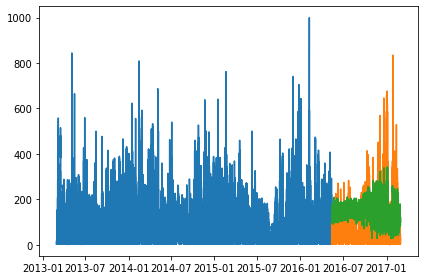

In [ ]:
plt.plot( X_train.index , X_train['PM2.5'], label = 'Training')
plt.plot( X_test.index , X_test['PM2.5'], label = 'Test')
plt.plot( X_test.index[100:], Y_pred[:,0], label = 'Pred')
plt.tight_layout()
plt.show()

In [ ]:
#cnn2d




input_shape = (X_train_seq.shape[1], X_train_seq.shape[2],1)


X_train_seq_cnn2d = X_train_seq.reshape(X_train_seq.shape[0], X_train_seq.shape[1], X_train_seq.shape[2],1)

X_test_seq_cnn2d = X_test_seq.reshape(X_test_seq.shape[0], X_test_seq.shape[1], X_test_seq.shape[2],1)





model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',
                 input_shape= input_shape))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

# model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D(strides=(2,2)))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2, activation='linear'))

learning_rate = 0.00001

model.compile(loss = 'mse',
              optimizer = Adam(learning_rate))

model.summary()



#Train the CNN

history = model.fit(X_train_seq_cnn2d,Y_train_seq_scaled , 
                    epochs = 20, batch_size = 256, 
                     verbose=1, 
                    validation_split=0.2)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 7, 16)         160       
_________________________________________________________________
batch_normalization (BatchNo (None, 98, 7, 16)         64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 5, 16)         2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 5, 16)         64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 2, 16)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 48, 2, 16)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)             

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
1052/1052 [==============================] - 288s 274ms/step - loss: 0.7132 - val_loss: 0.1398
Epoch 2/20
1052/1052 [==============================] - 284s 270ms/step - loss: 0.3010 - val_loss: 0.1287
Epoch 3/20
1052/1052 [==============================] - 287s 273ms/step - loss: 0.2416 - val_loss: 0.1139
Epoch 4/20
1052/1052 [==============================] - 284s 270ms/step - loss: 0.1999 - val_loss: 0.1005
Epoch 5/20
1052/1052 [==============================] - 287s 273ms/step - loss: 0.1666 - val_loss: 0.0825
Epoch 6/20
1052/1052 [==============================] - 285s 271ms/step - loss: 0.1396 - val_loss: 0.0672
Epoch 7/20
1052/1052 [==============================] - 286s 271ms/step - loss: 0.1175 - val_loss: 0.0591
Epoch 8/20
1052/1052 [==============================] - 289s 275ms/step - loss: 0.0997 - val_loss: 0.0538
Epoch 9/20
1052/1052 [==============================] - 288s 274ms/step - loss: 0.0856 - val_loss: 0.0524
Epoch 10/20
1052/1052 [=======================

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Test rmse: 75.79392928473712


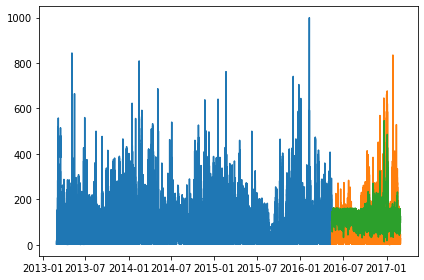

In [ ]:


results_cnn = (model.predict(X_test_seq_cnn2d))
Y_pred_cnn = ct_2.inverse_transform(results_cnn) 
#repreds_cnn = np.argmax(preds, axis=-1)


print('Test rmse:', np.sqrt(mean_squared_error(Y_test_seq[:,0],Y_pred_cnn[:,0])))



plt.plot( X_train.index , X_train['PM2.5'], label = 'Training')
plt.plot( X_test.index , X_test['PM2.5'], label = 'Test')
plt.plot( X_test.index[100:], Y_pred_cnn[:,0], label = 'Pred')
plt.tight_layout()
plt.show()

In [ ]:
 X_test.index[100:].shape

(84044,)

In [ ]:
Y_pred_cnn[:,0].shape

(84044,)